In [2]:
#necessary libraries
import pandas as pd
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score



In [3]:
#loading our datasets
may_data =pd.read_csv(os.path.join("data","may2023.csv"))
april_data =pd.read_csv(os.path.join("data","april2023.csv"))
march_data =pd.read_csv(os.path.join("data","march2023.csv"))

In [4]:
#merging the data for preprocessing
merged_data = pd.concat([march_data,april_data,may_data], axis=0, ignore_index=True)

In [5]:
merged_data.head(3)

,_id,DATE_TIME,LATITUDE,LONGITUDE,GEOHASH,MAXIMUM_SPEED,MINIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,1,2023-03-01 00:00:00,29.284058,41.075134,sxkcdm,109,42,76,116
1,2,2023-03-01 00:00:00,29.097290,40.948792,sxk8yn,82,9,42,27
2,3,2023-03-01 00:00:00,28.493042,41.113586,sxk3bk,93,67,82,6


In [6]:
import pandas as pd
import folium
from folium.plugins import HeatMap

In [7]:
merged_data.head(1)

,_id,DATE_TIME,LATITUDE,LONGITUDE,GEOHASH,MAXIMUM_SPEED,MINIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,1,2023-03-01 00:00:00,29.284058,41.075134,sxkcdm,109,42,76,116


In [8]:
# Assuming df is your DataFrame with columns 'time', 'latitude', 'longitude', and 'number_of_vehicles'

# Filter data for Istanbul, TR
istanbul_df = merged_data[(merged_data['LATITUDE'] >= 40.8027) & (merged_data['LATITUDE'] <= 41.2296) &
                 (merged_data['LONGITUDE'] >= 28.8974) & (merged_data['LONGITUDE'] <= 29.3599)]

# Create a Folium map centered around Istanbul
istanbul_map = folium.Map(location=[41.0082, 28.9784], zoom_start=12)

# Add markers for each data point
for index, row in istanbul_df.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=f"Time: {row['DATE_TIME']}, Vehicles: {row['NUMBER_OF_VEHICLES']}",
        icon=folium.Icon(color='blue')
    ).add_to(istanbul_map)

# Save the map to an HTML file
istanbul_map.save("istanbul_map.html")

In [ ]:
# Convert the 'datetime' column to a pandas datetime object
merged_data['DATE_TIME'] = pd.to_datetime(merged_data['DATE_TIME'])

# Extract the date and hour from the 'datetime' column
merged_data['date'] = merged_data['DATE_TIME'].dt.date
merged_data['hour'] = merged_data['DATE_TIME'].dt.hour

# Initialize a list to store the results
time_data_list = []

# Iterate through unique date-hour combinations
for date_hour, group in merged_data.groupby(['date', 'hour']):
    date, hour = date_hour
    num_of_vehicles_list = group['NUMBER_OF_VEHICLES'].tolist()
    
    # Calculate the average of num_of_vehicles for the current date-hour combination
    average_num_of_vehicles = sum(num_of_vehicles_list) / len(num_of_vehicles_list)

    # Append the result to the time_data_list
    time_data_list.append({'date-hour': f'{date} {hour:02d}', 'average_num_of_vehicles': average_num_of_vehicles})

# Convert the list of dictionaries to a DataFrame
time_data = pd.DataFrame(time_data_list)

In [7]:
#convert data-type
time_data['date-hour'] = pd.to_datetime(time_data['date-hour'], format='%Y-%m-%d %H')

In [8]:
#checking for null values
time_data.isna().sum()

date-hour                  0
average_num_of_vehicles    0
dtype: int64

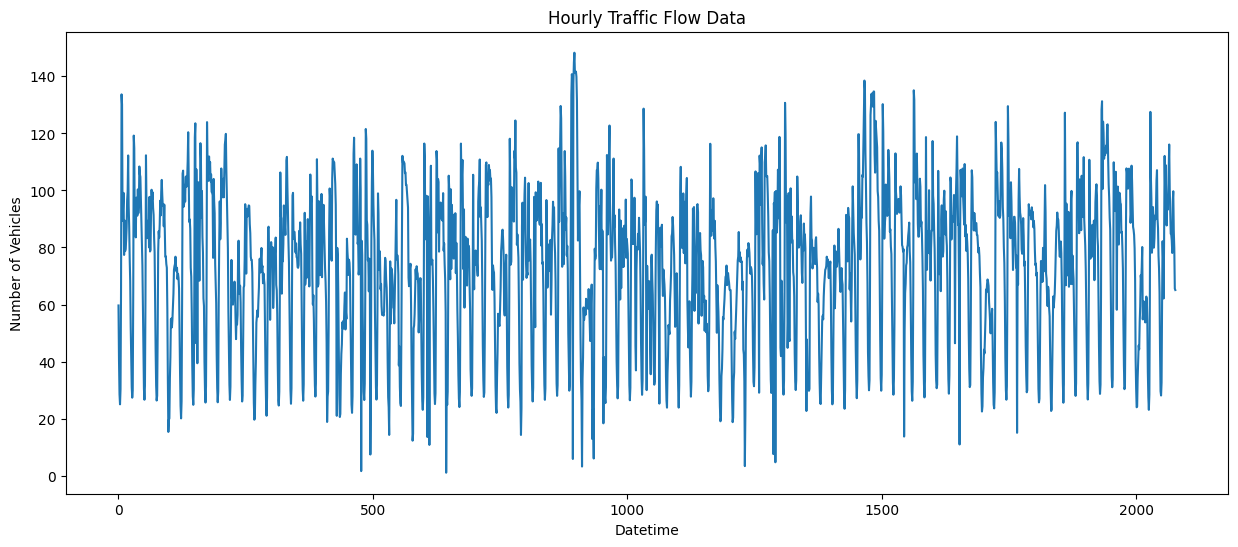

In [9]:
# Plot the original data to visualize the traffic flow
plt.figure(figsize=(15, 6))
plt.plot(time_data.index, time_data['average_num_of_vehicles'])
plt.title('Hourly Traffic Flow Data')
plt.xlabel('Datetime')
plt.ylabel('Number of Vehicles')
plt.show()




Epoch 1/40

83/83 [==============================] - 5s 18ms/step - loss: 0.0528 - val_loss: 0.0350
Epoch 2/40
83/83 [==============================] - 1s 11ms/step - loss: 0.0307 - val_loss: 0.0302
Epoch 3/40
83/83 [==============================] - 1s 11ms/step - loss: 0.0274 - val_loss: 0.0306
Epoch 4/40
83/83 [==============================] - 1s 11ms/step - loss: 0.0260 - val_loss: 0.0265
Epoch 5/40
83/83 [==============================] - 1s 11ms/step - loss: 0.0238 - val_loss: 0.0248
Epoch 6/40
83/83 [==============================] - 1s 11ms/step - loss: 0.0229 - val_loss: 0.0226
Epoch 7/40
83/83 [==============================] - 1s 12ms/step - loss: 0.0198 - val_loss: 0.0192
Epoch 8/40
83/83 [==============================] - 1s 12ms/step - loss: 0.0184 - val_loss: 0.0156
Epoch 9/40
83/83 [==============================] - 1s 11ms/step - loss: 0.0160 - val_loss: 0.0150
Epoch 10/40
83/83 [==============================] - 1s 11ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 

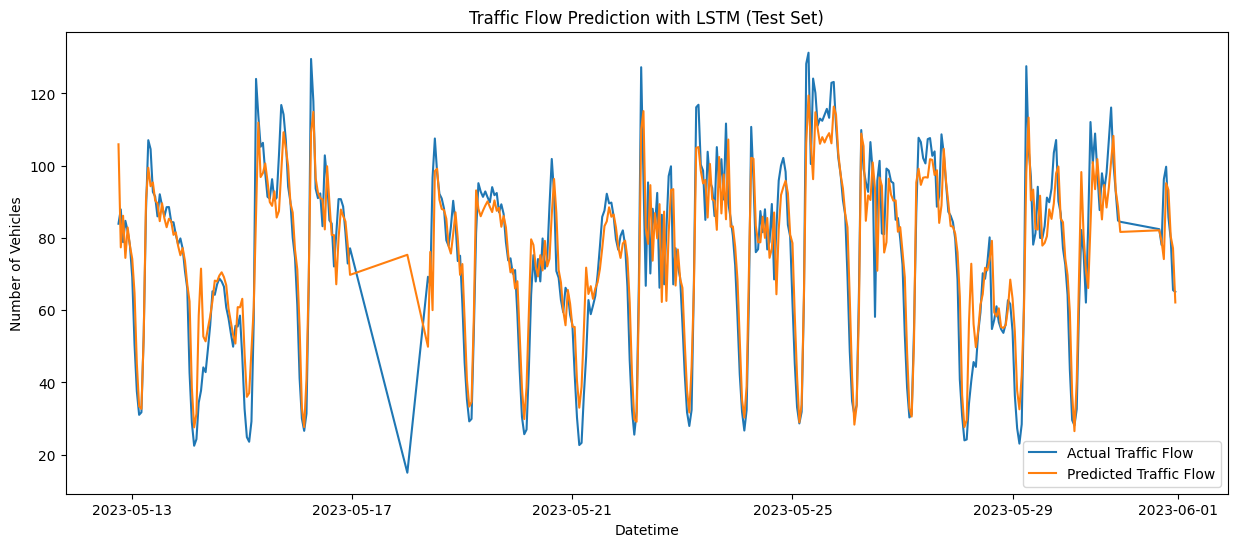

In [10]:

# Convert 'date-hour' to datetime and set it as the index
time_data['date-hour'] = pd.to_datetime(time_data['date-hour'])
time_data.set_index('date-hour', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_data)

# Create sequences for the LSTM model
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps, 0])  # Assuming 'average_num_of_vehicles' is at index 0
    return np.array(X), np.array(y)

n_steps = 10
X, y = create_sequences(scaled_data, n_steps)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=40, batch_size=16, validation_split=0.2)

# Make predictions on the test set
test_predict = model.predict(X_test)

# Inverse transform the predictions to get the actual values
test_predict = scaler.inverse_transform(np.hstack([test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))]))

# Plot the predictions against the actual values for the test set
plt.figure(figsize=(15, 6))
plt.plot(time_data.index[train_size + n_steps:], scaler.inverse_transform(scaled_data)[train_size + n_steps:], label='Actual Traffic Flow')
plt.plot(time_data.index[train_size + n_steps:], test_predict, label='Predicted Traffic Flow')
plt.title('Traffic Flow Prediction with LSTM (Test Set)')
plt.xlabel('Datetime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

In [12]:
# Inverse transform the actual values for the test set
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate additional evaluation metrics
mae = mean_absolute_error(actual_values, test_predict)
r2 = r2_score(actual_values, test_predict)

# Print the evaluation metrics
print("Test RMSE:", test_rmse)
print("Mean Absolute Error:", mae)
print("R-squared (R2) Score:", r2)

Test RMSE: 10.755395164889864
Mean Absolute Error: 7.825914720794813
R-squared (R2) Score: 0.8220267772156074
